In [2]:
import pandas as pd
import torchaudio
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pipetorch.train import *
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import math
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import WeightedRandomSampler

using gpu 3


In [3]:
df = pd.read_csv('../nourish/res/dataset_tensors_melspec/train/audio_train_augmented_melspec_tensors.csv')
df

,filename,modification,label
0,-4wthmfwlwQ_260.pt,None,chewing
1,-5IpgOv9HD0_30.pt,None,chewing
2,-KO1p22zjVc_470.pt,None,chewing
3,-t-lmWNCXt0_10.pt,None,chewing
4,-t95P0R9Pf0_60.pt,None,chewing
...,...,...,...
7827,4gBf0FWwKnQ_100_squeezed.pt,squeezed,other
7828,4gBf0FWwKnQ_100_extended.pt,extended,other
7829,4gBf0FWwKnQ_100_shiftRight.pt,shiftRight,other
7830,4gBf0FWwKnQ_100_shiftLeft.pt,shiftLeft,other


In [4]:
class AudioSet(Dataset):
    def __init__(self, df, root_dir, in_col, out_col, length_sec, sampling_rate):
        self.df = df
        self.root_dir = root_dir
        self.in_col = in_col
        self.out_col = out_col
        self.length_sec = length_sec
        self.sampling_rate = sampling_rate
        
        self.c2i = {'chewing': 1, 'drinking': 0, 'other': 1}
        self.i2c = {0: 'drinking', 1: 'other'}
        
    def __getitem__(self, index):
        filepath = self.root_dir + self.df.iloc[index][self.in_col]
        data = torch.load(filepath)
        label = self.c2i[self.df.iloc[index][self.out_col]]
        return data.cuda(), label
        
    def __len__(self):
        return len(self.df)

In [5]:
def my_precision_score(true_y, pred_y):
    return precision_score(true_y, pred_y, average=None)

In [6]:
def my_recall_score(true_y, pred_y):
    return recall_score(true_y, pred_y, average=None)

In [7]:
def sort_epochs(results, by):
    results = results[results['phase'] != '']
    results[['prec_drinking', 'prec_other']] = pd.DataFrame(results['my_precision_score'].tolist(), index=results.index)
    results[['recall_drinking', 'recall_other']] = pd.DataFrame(results['my_recall_score'].tolist(), index=results.index)

    results = results[results['phase'] == 'valid']
    results = results.sort_values(by, ascending=False)
    print(results[['accuracy_score', 'epoch', 'prec_drinking', 'recall_drinking', 'recall_other']])

In [8]:

# thanks to https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
# modified the function a little to fit our needs

def make_confusion_matrix(true_y,
                          pred_y,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''
    
    cf = confusion_matrix(true_y, pred_y)
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [round(value / np.sum(cf[i // 3]) * 100, 2) for i, value in enumerate(cf.flatten())]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}%".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))


        #Metrics for Binary Confusion Matrices
        precision = precision_score(true_y, pred_y, average=None)
        
        stats_text = "\n\nAccuracy={:0.3f}\nPrecision Drinking={:0.3f}\n Precision other={:0.3f}\n".format(
            accuracy, precision[0], precision[1])
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    
    group_percentages = np.reshape(group_percentages, (2, 2))

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(
        group_percentages,annot=box_labels,
        fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,
        yticklabels=categories, vmin=0, vmax=100)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [9]:
c2i = {'chewing': 1, 'drinking': 0, 'other': 1}

def predict_test_set(model, df_test, audio_dir, print_wrong=True, gpu=True):
    model = model.cuda() if gpu else model.cpu()
    
    # get labels and filenames
    true_y = [c2i[label] for label in df_test['label'].values]
    filenames = df_test['filename'].values
    pred_y = []
    
    for filename in filenames:
        t = torch.load(audio_dir + filename)
        t = t.cuda() if gpu else t.cpu()
        t = t[None, :] # expand the tensor
        
        with torch.no_grad():
            pred = model(t)
            pred = model.post_forward(pred)
            pred_y.append(pred.data.cpu().numpy()[0])
    # plot conf matrix
    make_confusion_matrix(true_y, pred_y)
    plt.show()
    
    if print_wrong:
        # get false negatives and false positives of eating and drinking
        fn_eating_ind = []
        fn_drinking_ind = []
        fp_eating_ind = []
        fp_drinking_ind = []
        for i, y in enumerate(zip(true_y, pred_y)):
            if(y[0] != y[1]):
                # fn eating
                if y[0] == 0:
                    fn_eating_ind.append(i)
                
                # fn drinking
                if y[0] == 1:
                    fn_drinking_ind.append(i)
                
                # fp eating
                if y[1] == 0:
                    fp_eating_ind.append(i)
            
                # fp drinking
                if y[1] == 1:
                    fp_drinking_ind.append(i)
                
        fn_eating_filenames = [filenames[i] for i in fn_eating_ind]
        fn_drinking_filenames = [filenames[i] for i in fn_drinking_ind]
        fp_eating_filenames = [filenames[i] for i in fp_eating_ind]
        fp_drinking_filenames = [filenames[i] for i in fp_drinking_ind]
    
        # print it
        print('FALSE NEGATIVES EATING:', end='\n\t')
        print('\n\t'.join(fn_eating_filenames))
        print('FALSE NEGATIVES DRINKING:', end='\n\t')
        print('\n\t'.join(fn_drinking_filenames))
        print('FALSE POSITIVES EATING:', end='\n\t')
        print('\n\t'.join(fp_eating_filenames))
        print('FALSE POSITIVES DRINKING:', end='\n\t')
        print('\n\t'.join(fp_drinking_filenames))

In [10]:
df_pos = df[df['label']=='drinking']
df_neg = df.drop(df_pos.index)
bdf_neg = df_neg.sample(n=len(df_pos.index))
bdf = pd.concat([df_pos, bdf_neg])

In [11]:
df_valid = bdf.sample(n=int((len(bdf.index))/5))
df_train = bdf.drop(df_valid.index)
df_test = pd.read_csv('../nourish/res/dataset_tensors_melspec/test/audio_test_melspec_tensors.csv')
# shuffling the sets
df_valid = df_valid.sample(frac=1)
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
df_train

,filename,modification,label
4921,drinks_6_17_pitched_down.pt,pitched_down,drinking
1963,-4wthmfwlwQ_260_shiftRight.pt,shiftRight,chewing
6460,08NwoFomOds_130_pitched_up.pt,pitched_up,other
2164,2-PhFBwwOiM_19_squeezed.pt,squeezed,chewing
2137,1mCEzdPC8xQ_360_extended.pt,extended,chewing
...,...,...,...
3795,drinks_11_17_squeezed.pt,squeezed,drinking
4178,drinks_2_25_pitched_up.pt,pitched_up,drinking
4937,drinks_6_19_extended.pt,extended,drinking
2295,3Yprz_bSKeQ_50_pitched_up.pt,pitched_up,chewing


In [12]:
batch_size = 64

root_dir_train = '../nourish/res/dataset_tensors_melspec/train/audio/'
root_dir_test = '../nourish/res/dataset_tensors_melspec/test/audio/'
train_data = AudioSet(df_train, root_dir_train, 'filename', 'label', 10, 16000)
valid_data = AudioSet(df_valid, root_dir_train, 'filename', 'label', 10, 16000)
test_data = AudioSet(df_test, root_dir_test, 'filename', 'label', 10, 16000)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__(), shuffle=True)

lr = 0.001
epochs = 100

metrics = [accuracy_score, my_precision_score, my_recall_score]

# 1 conv 1 lin

In [74]:
class cnn1Layer1(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(self.out_channels*16*100 , 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = X.reshape(-1, self.out_channels*16*100)
        X = self.w1(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [75]:
cnn1_model = cnn1Layer1(4)
cnn1_trainer = trainer(cnn1_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn1_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/448000 [00:00<?, ?it/s]

  1 2.83s trainloss=113.63774 validloss=84.43754 accuracy_score=0.65801 
  2 2.81s trainloss=38.11102 validloss=76.41354 accuracy_score=0.68736 
  3 2.84s trainloss=20.99392 validloss=58.41822 accuracy_score=0.69074 
  4 2.77s trainloss=12.00463 validloss=52.49638 accuracy_score=0.69977 
  5 2.73s trainloss=9.29542 validloss=50.44150 accuracy_score=0.71558 
  6 2.73s trainloss=7.18486 validloss=43.76663 accuracy_score=0.72348 
  7 2.72s trainloss=6.00584 validloss=34.75732 accuracy_score=0.70880 
  8 2.72s trainloss=5.69599 validloss=37.01804 accuracy_score=0.71106 
  9 2.73s trainloss=4.34349 validloss=33.17779 accuracy_score=0.73138 
 10 2.75s trainloss=3.55857 validloss=33.80462 accuracy_score=0.73025 
 11 2.79s trainloss=3.55789 validloss=33.79054 accuracy_score=0.73476 
 12 2.77s trainloss=3.12068 validloss=31.25807 accuracy_score=0.72799 
 13 2.78s trainloss=2.74273 validloss=32.40446 accuracy_score=0.73815 
 14 2.77s trainloss=3.63795 validloss=25.47872 accuracy_score=0.73138 
 

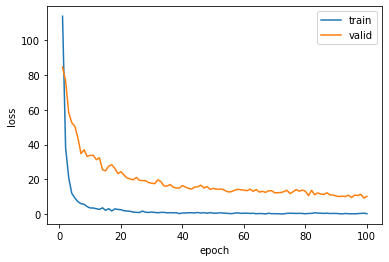

In [76]:
cnn1_trainer.learning_curve()

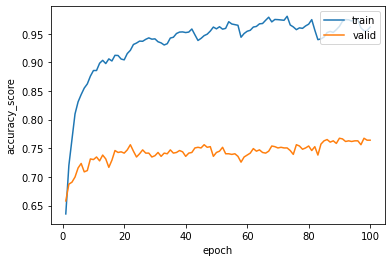

In [77]:
cnn1_trainer.learning_curve(y='accuracy_score')

In [78]:
sort_epochs(cnn1_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_drinking  recall_drinking  recall_other
195        0.767494   98.0       0.753363         0.777778      0.757709
179        0.767494   90.0       0.747807         0.789352      0.746696
181        0.766366   91.0       0.761021         0.759259      0.773128
171        0.765237   86.0       0.748889         0.780093      0.751101
199        0.764108  100.0       0.748330         0.777778      0.751101
..              ...    ...            ...              ...           ...
13         0.708804    7.0       0.731383         0.636574      0.777533
7          0.699774    4.0       0.701456         0.668981      0.729075
5          0.690745    3.0       0.668085         0.726852      0.656388
3          0.687359    2.0       0.655936         0.754630      0.623348
1          0.658014    1.0       0.682720         0.557870      0.753304

[100 rows x 5 columns]


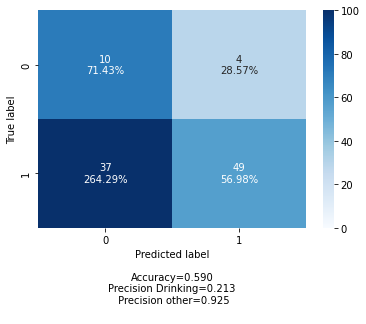

In [79]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn1_model = cnn1_model.cuda()

with torch.no_grad():
        pred_y = cnn1_model(test_X)
        pred_y = cnn1_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# 1 conv 2 lin

In [80]:
class cnn1Layer2(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(self.out_channels*16*100 , 100)
        self.w2 = nn.Linear(100, 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = X.reshape(-1, self.out_channels*16*100)
        X = self.w1(X)
        X = self.w2(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [81]:
cnn1_2_model = cnn1Layer2(4)
cnn1_2_trainer = trainer(cnn1_2_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn1_2_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/448000 [00:00<?, ?it/s]

  1 2.73s trainloss=547.74844 validloss=94.44643 accuracy_score=0.65801 
  2 2.71s trainloss=50.90620 validloss=29.27574 accuracy_score=0.68284 
  3 2.71s trainloss=10.13407 validloss=12.39089 accuracy_score=0.67494 
  4 2.73s trainloss=5.10771 validloss=6.61778 accuracy_score=0.67043 
  5 2.72s trainloss=1.79751 validloss=5.54584 accuracy_score=0.64221 
  6 2.71s trainloss=1.29843 validloss=3.97216 accuracy_score=0.70880 
  7 2.70s trainloss=1.28202 validloss=3.35956 accuracy_score=0.71896 
  8 2.71s trainloss=1.40710 validloss=4.33867 accuracy_score=0.71896 
  9 2.71s trainloss=2.07325 validloss=4.98581 accuracy_score=0.66930 
 10 2.71s trainloss=1.03168 validloss=3.11473 accuracy_score=0.70316 
 11 2.70s trainloss=0.97295 validloss=3.61648 accuracy_score=0.71558 
 12 2.71s trainloss=1.27593 validloss=3.45371 accuracy_score=0.71219 
 13 2.71s trainloss=1.14333 validloss=3.96133 accuracy_score=0.68623 
 14 2.71s trainloss=1.29416 validloss=3.98252 accuracy_score=0.71332 
 15 2.71s tra

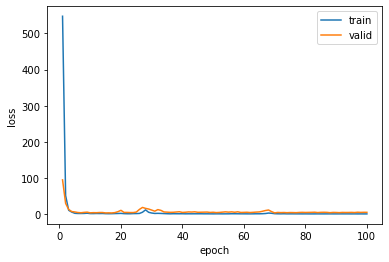

In [82]:
cnn1_2_trainer.learning_curve()

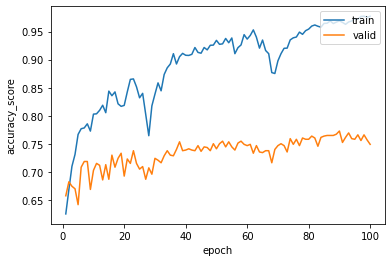

In [83]:
cnn1_2_trainer.learning_curve(y='accuracy_score')

In [84]:
sort_epochs(cnn1_2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_drinking  recall_drinking  recall_other
179        0.773138   90.0       0.759551         0.782407      0.764317
185        0.769752   93.0       0.744635         0.803241      0.737885
177        0.767494   89.0       0.751111         0.782407      0.753304
195        0.766366   98.0       0.753950         0.773148      0.759912
191        0.766366   96.0       0.749446         0.782407      0.751101
..              ...    ...            ...              ...           ...
5          0.674944    3.0       0.665138         0.671296      0.678414
7          0.670429    4.0       0.652174         0.694444      0.647577
17         0.669300    9.0       0.672457         0.627315      0.709251
1          0.658014    1.0       0.660848         0.613426      0.700441
9          0.642212    5.0       0.607076         0.754630      0.535242

[100 rows x 5 columns]


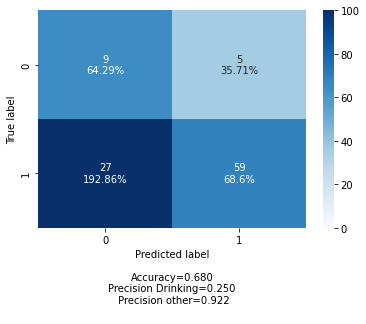

In [85]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn1_2_model = cnn1_2_model.cuda()

with torch.no_grad():
        pred_y = cnn1_2_model(test_X)
        pred_y = cnn1_2_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# 2conv1lin

In [86]:
class cnn2Layer1(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(self.out_channels, 2*self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(2*self.out_channels*8*50 , 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = X.reshape(-1, 2*self.out_channels*8*50)
        X = self.w1(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [87]:
cnn2_model = cnn2Layer1(4)
cnn2_trainer = trainer(cnn2_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn2_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/448000 [00:00<?, ?it/s]

  1 2.90s trainloss=60.68381 validloss=27.48518 accuracy_score=0.65237 
  2 2.89s trainloss=15.96664 validloss=11.66836 accuracy_score=0.69300 
  3 2.89s trainloss=7.04663 validloss=8.38201 accuracy_score=0.70316 
  4 2.90s trainloss=4.70801 validloss=8.09231 accuracy_score=0.70316 
  5 2.89s trainloss=3.34834 validloss=6.08658 accuracy_score=0.71896 
  6 2.90s trainloss=2.07530 validloss=5.27266 accuracy_score=0.73025 
  7 2.90s trainloss=1.62804 validloss=5.21217 accuracy_score=0.72799 
  8 2.89s trainloss=1.63469 validloss=6.19554 accuracy_score=0.71106 
  9 2.90s trainloss=1.72456 validloss=4.07535 accuracy_score=0.72686 
 10 2.89s trainloss=1.28346 validloss=4.58783 accuracy_score=0.73251 
 11 2.89s trainloss=0.93491 validloss=3.71072 accuracy_score=0.72912 
 12 2.90s trainloss=1.02519 validloss=4.80264 accuracy_score=0.74379 
 13 2.89s trainloss=0.98800 validloss=3.87874 accuracy_score=0.74266 
 14 2.90s trainloss=0.75840 validloss=3.67997 accuracy_score=0.73138 
 15 2.90s trainl

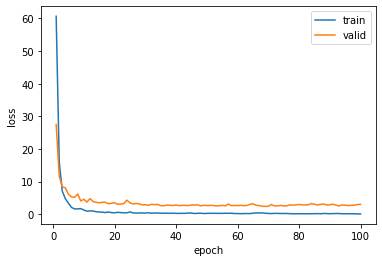

In [88]:
cnn2_trainer.learning_curve()

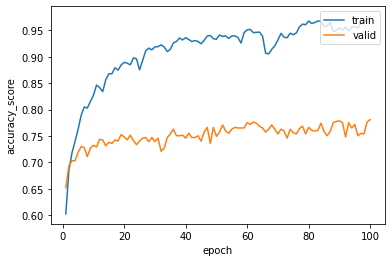

In [89]:
cnn2_trainer.learning_curve(y='accuracy_score')

In [90]:
sort_epochs(cnn2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_drinking  recall_drinking  recall_other
199        0.781038  100.0       0.779343         0.768519      0.792952
179        0.778781   90.0       0.786408         0.750000      0.806167
177        0.777652   89.0       0.793017         0.736111      0.817181
197        0.776524   99.0       0.775943         0.761574      0.790749
123        0.776524   62.0       0.786765         0.743056      0.808370
..              ...    ...            ...              ...           ...
15         0.711061    8.0       0.780255         0.567130      0.848018
7          0.703160    4.0       0.670020         0.770833      0.638767
5          0.703160    3.0       0.693364         0.701389      0.704846
3          0.693002    2.0       0.666667         0.740741      0.647577
1          0.652370    1.0       0.736641         0.446759      0.848018

[100 rows x 5 columns]


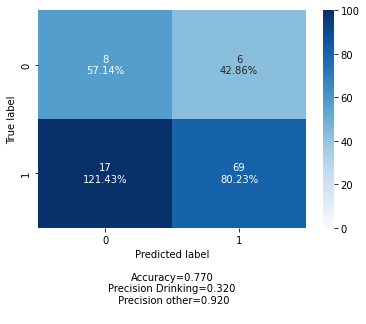

In [91]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn2_model = cnn2_model.cuda()

with torch.no_grad():
        pred_y = cnn2_model(test_X)
        pred_y = cnn2_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# 2conv2lin

In [92]:
class cnn2Layer2(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(self.out_channels, 2*self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(2*self.out_channels*8*50 , 100)
        self.w2 = nn.Linear(100, 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = X.reshape(-1, 2*self.out_channels*8*50)
        X = self.w1(X)
        X = self.w2(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [93]:
cnn2_2_model = cnn2Layer2(4)
cnn2_2_trainer = trainer(cnn2_2_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn2_2_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/448000 [00:00<?, ?it/s]

  1 4.24s trainloss=113.06108 validloss=14.19650 accuracy_score=0.65124 
  2 4.33s trainloss=5.96035 validloss=6.29011 accuracy_score=0.67720 
  3 4.37s trainloss=2.60451 validloss=4.43036 accuracy_score=0.72122 
  4 4.54s trainloss=2.02357 validloss=3.59568 accuracy_score=0.72912 
  5 4.45s trainloss=1.51081 validloss=2.94256 accuracy_score=0.72912 
  6 4.29s trainloss=0.92619 validloss=2.56325 accuracy_score=0.74831 
  7 4.31s trainloss=0.63724 validloss=2.30476 accuracy_score=0.71670 
  8 4.50s trainloss=0.55725 validloss=2.31624 accuracy_score=0.76411 
  9 4.46s trainloss=0.44710 validloss=1.99815 accuracy_score=0.74718 
 10 4.44s trainloss=0.40471 validloss=2.01784 accuracy_score=0.73251 
 11 4.76s trainloss=0.40036 validloss=2.31888 accuracy_score=0.74605 
 12 4.63s trainloss=0.37715 validloss=2.11417 accuracy_score=0.75282 
 13 4.98s trainloss=0.33283 validloss=2.13493 accuracy_score=0.74944 
 14 4.75s trainloss=0.33418 validloss=2.23447 accuracy_score=0.74944 
 15 4.58s trainlo

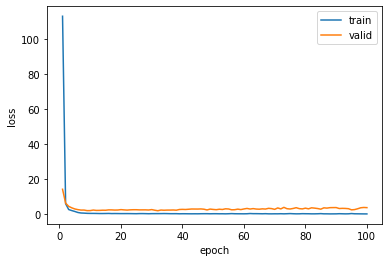

In [94]:
cnn2_2_trainer.learning_curve()

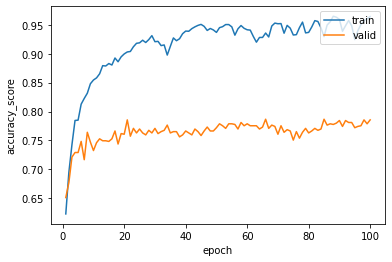

In [95]:
cnn2_2_trainer.learning_curve(y='accuracy_score')

In [96]:
sort_epochs(cnn2_2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_drinking  recall_drinking  recall_other
169        0.786682   85.0       0.788599         0.768519      0.803965
131        0.786682   66.0       0.771812         0.798611      0.775330
199        0.785553  100.0       0.792271         0.759259      0.810573
41         0.785553   21.0       0.776256         0.787037      0.784141
195        0.785553   98.0       0.782710         0.775463      0.795154
..              ...    ...            ...              ...           ...
7          0.729120    4.0       0.715247         0.738426      0.720264
5          0.721219    3.0       0.739018         0.662037      0.777533
13         0.716704    7.0       0.762319         0.608796      0.819383
3          0.677201    2.0       0.728125         0.539352      0.808370
1          0.651242    1.0       0.639456         0.652778      0.649780

[100 rows x 5 columns]


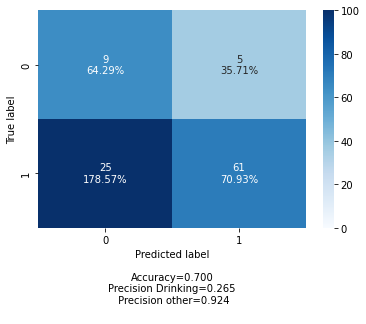

In [97]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn2_2_model = cnn2_2_model.cuda()

with torch.no_grad():
        pred_y = cnn2_2_model(test_X)
        pred_y = cnn2_2_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# ResNet

In [13]:
# nSamples = [1696, 2216, 3920] #of class instances
nSamples = [1696 + 2216, 3920] #of class instances
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights).cuda()

In [14]:
def post_forward(y):
    return torch.argmax(y, axis=1)

# resnet 18

In [42]:
rn18 = models.resnet18(pretrained=True)
rn18.conv1 = nn.Conv2d(1, rn18.conv1.out_channels,
              kernel_size=rn18.conv1.kernel_size[0], 
                      stride=rn18.conv1.stride[0], 
                      padding=rn18.conv1.padding[0])
num_ftrs = rn18.fc.in_features
rn18.fc = nn.Linear(num_ftrs, 2)

rn18.post_forward = post_forward

rn18_trainer = trainer(rn18, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [43]:
rn18_trainer.train(100, lr=0.01, weight_decay=0.8)

Total:   0%|          | 0/448000 [00:00<?, ?it/s]

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  1 10.15s trainloss=0.91586 validloss=0.75003 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  2 10.15s trainloss=0.71219 validloss=0.71079 accuracy_score=0.48081 
  3 10.30s trainloss=0.69607 validloss=0.69181 accuracy_score=0.52370 
  4 10.31s trainloss=0.64399 validloss=2.59341 accuracy_score=0.58691 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  5 8.82s trainloss=0.58849 validloss=0.78710 accuracy_score=0.48081 
  6 5.93s trainloss=0.57482 validloss=2.11820 accuracy_score=0.59368 
  7 5.92s trainloss=0.57229 validloss=0.75499 accuracy_score=0.49210 
  8 5.96s trainloss=0.64558 validloss=0.69932 accuracy_score=0.48420 
  9 5.94s trainloss=0.58752 validloss=136.31336 accuracy_score=0.55192 
 10 5.85s trainloss=0.58482 validloss=3.96172 accuracy_score=0.54402 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 11 5.86s trainloss=0.56169 validloss=0.70397 accuracy_score=0.48081 
 12 5.90s trainloss=0.57673 validloss=5.83275 accuracy_score=0.56772 
 13 5.88s trainloss=0.55539 validloss=41.28252 accuracy_score=0.51919 
 14 5.91s trainloss=0.59211 validloss=16.55045 accuracy_score=0.54515 
 15 5.99s trainloss=0.59035 validloss=0.55145 accuracy_score=0.71106 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 16 6.13s trainloss=0.57127 validloss=0.70873 accuracy_score=0.48081 
 17 5.93s trainloss=0.56539 validloss=1.45250 accuracy_score=0.61738 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 18 5.96s trainloss=0.59623 validloss=0.69241 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 19 6.03s trainloss=0.57660 validloss=0.76812 accuracy_score=0.48081 
 20 6.04s trainloss=0.59296 validloss=0.62443 accuracy_score=0.64221 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 21 5.98s trainloss=0.60933 validloss=0.70011 accuracy_score=0.48081 
 22 6.01s trainloss=0.69279 validloss=0.71016 accuracy_score=0.47856 
 23 5.88s trainloss=0.64022 validloss=1.23287 accuracy_score=0.70880 
 24 4.09s trainloss=0.61775 validloss=0.56646 accuracy_score=0.72348 
 25 4.09s trainloss=0.57560 validloss=0.75834 accuracy_score=0.54966 
 26 4.05s trainloss=0.57418 validloss=0.53151 accuracy_score=0.73138 
 27 4.07s trainloss=0.54274 validloss=0.86157 accuracy_score=0.47968 
 28 4.09s trainloss=0.55906 validloss=0.80169 accuracy_score=0.66366 
 29 4.19s trainloss=0.52324 validloss=0.74493 accuracy_score=0.60948 
 30 4.08s trainloss=0.59765 validloss=0.70084 accuracy_score=0.60497 
 31 4.08s trainloss=0.57564 validloss=0.92620 accuracy_score=0.52370 
 32 4.08s trainloss=0.57101 validloss=0.88388 accuracy_score=0.54853 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 33 4.08s trainloss=0.57536 validloss=0.74547 accuracy_score=0.51919 
 34 4.08s trainloss=0.55427 validloss=0.58023 accuracy_score=0.69300 
 35 4.08s trainloss=0.57319 validloss=0.61393 accuracy_score=0.67269 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 36 4.12s trainloss=0.58428 validloss=0.69321 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 37 4.08s trainloss=0.57833 validloss=0.72158 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 38 4.17s trainloss=0.68314 validloss=0.69246 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 39 4.10s trainloss=0.69398 validloss=0.69291 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 40 4.09s trainloss=0.69334 validloss=0.69442 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 41 4.09s trainloss=0.69337 validloss=0.69415 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 4.26s trainloss=0.69342 validloss=0.69367 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 43 4.11s trainloss=0.69327 validloss=0.69339 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 44 4.24s trainloss=0.69339 validloss=0.69317 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 45 4.05s trainloss=0.69344 validloss=0.69465 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 46 4.05s trainloss=0.69326 validloss=0.69306 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 47 4.05s trainloss=0.69322 validloss=0.69385 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 4.05s trainloss=0.69334 validloss=0.69359 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 49 4.05s trainloss=0.69335 validloss=0.69296 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 50 4.05s trainloss=0.69313 validloss=0.69485 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 51 4.04s trainloss=0.69359 validloss=0.69336 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 52 4.23s trainloss=0.69345 validloss=0.69300 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 53 4.10s trainloss=0.69348 validloss=0.69297 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 4.06s trainloss=0.69328 validloss=0.69402 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 55 4.08s trainloss=0.69362 validloss=0.69355 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 56 4.09s trainloss=0.69351 validloss=0.69397 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 57 4.10s trainloss=0.69326 validloss=0.69366 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 58 4.20s trainloss=0.69329 validloss=0.69315 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 59 4.08s trainloss=0.69334 validloss=0.69274 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 4.08s trainloss=0.69350 validloss=0.69249 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 61 4.07s trainloss=0.69350 validloss=0.69419 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 62 4.10s trainloss=0.69325 validloss=0.69364 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 63 4.13s trainloss=0.69329 validloss=0.69456 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 64 4.10s trainloss=0.69382 validloss=0.69387 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 65 4.09s trainloss=0.69343 validloss=0.69274 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 66 4.09s trainloss=0.69309 validloss=0.69410 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 67 4.09s trainloss=0.69307 validloss=0.69245 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 68 4.11s trainloss=0.69367 validloss=0.69452 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 69 4.10s trainloss=0.69347 validloss=0.69381 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 70 4.30s trainloss=0.69350 validloss=0.69373 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 71 4.07s trainloss=0.69327 validloss=0.69344 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 72 4.14s trainloss=0.69341 validloss=0.69361 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 73 4.08s trainloss=0.69370 validloss=0.69313 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 74 4.08s trainloss=0.69326 validloss=0.69354 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 75 4.08s trainloss=0.69341 validloss=0.69388 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 76 4.09s trainloss=0.69361 validloss=0.69294 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 4.31s trainloss=0.69321 validloss=0.69413 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 78 5.57s trainloss=0.69330 validloss=0.69434 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 79 5.56s trainloss=0.69356 validloss=0.69349 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 80 5.55s trainloss=0.69350 validloss=0.69365 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 81 5.54s trainloss=0.69326 validloss=0.69383 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 82 5.36s trainloss=0.69356 validloss=0.69524 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 83 5.33s trainloss=0.69377 validloss=0.69309 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 84 5.42s trainloss=0.69316 validloss=0.69482 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 5.42s trainloss=0.69390 validloss=0.69535 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 86 5.32s trainloss=0.69316 validloss=0.69274 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 5.43s trainloss=0.69312 validloss=0.69569 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88 5.51s trainloss=0.69355 validloss=0.69481 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89 5.42s trainloss=0.69364 validloss=0.69435 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 90 5.40s trainloss=0.69321 validloss=0.69301 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 91 5.51s trainloss=0.69330 validloss=0.69269 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 92 5.53s trainloss=0.69313 validloss=0.69529 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 93 5.46s trainloss=0.69371 validloss=0.69383 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 5.49s trainloss=0.69360 validloss=0.69393 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 95 5.48s trainloss=0.69360 validloss=0.69399 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 96 4.32s trainloss=0.69339 validloss=0.69435 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 97 4.09s trainloss=0.69412 validloss=0.69386 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 98 4.10s trainloss=0.69336 validloss=0.69396 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 99 4.09s trainloss=0.69339 validloss=0.69460 accuracy_score=0.48081 
100 4.20s trainloss=0.69348 validloss=0.69435 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


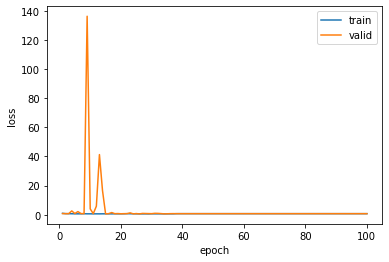

In [44]:
rn18_trainer.learning_curve()

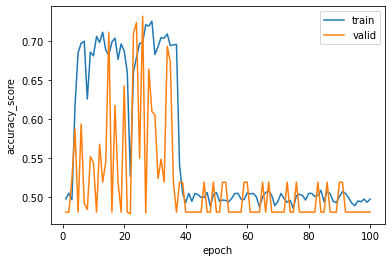

In [45]:
rn18_trainer.learning_curve(y='accuracy_score')

In [46]:
sort_epochs(rn18_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_drinking  recall_drinking  recall_other
51         0.731377   26.0       0.776471         0.619718      0.834783
47         0.723476   24.0       0.687371         0.779343      0.671739
29         0.711061   15.0       0.642140         0.901408      0.534783
45         0.708804   23.0       0.703883         0.680751      0.734783
67         0.693002   34.0       0.682464         0.676056      0.708696
..              ...    ...            ...              ...           ...
127        0.480813   64.0       0.480813         1.000000      0.000000
131        0.480813   66.0       0.480813         1.000000      0.000000
199        0.480813  100.0       0.480813         1.000000      0.000000
53         0.479684   27.0       0.480226         0.997653      0.000000
43         0.478555   22.0       0.479638         0.995305      0.000000

[100 rows x 5 columns]


# resnet 34

In [47]:
rn34 = models.resnet34(pretrained=True)
rn34.conv1 = nn.Conv2d(1, rn34.conv1.out_channels,
              kernel_size=rn34.conv1.kernel_size[0], 
                      stride=rn34.conv1.stride[0], 
                      padding=rn34.conv1.padding[0])
num_ftrs = rn34.fc.in_features
rn34.fc = nn.Linear(num_ftrs, 2)

rn34.post_forward = post_forward

rn34_trainer = trainer(rn18, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [48]:
rn34_trainer.train(100, lr=0.01, weight_decay=0.5)

Total:   0%|          | 0/448000 [00:00<?, ?it/s]

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  1 5.04s trainloss=0.69362 validloss=0.69298 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  2 5.06s trainloss=0.69340 validloss=0.69405 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  3 5.01s trainloss=0.69352 validloss=0.69556 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  4 5.00s trainloss=0.69377 validloss=0.69375 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  5 5.01s trainloss=0.69347 validloss=0.69334 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  6 5.01s trainloss=0.69338 validloss=0.69279 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  7 5.00s trainloss=0.69327 validloss=0.69416 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  8 5.03s trainloss=0.69352 validloss=0.69370 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  9 4.09s trainloss=0.69341 validloss=0.69381 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 10 4.09s trainloss=0.69391 validloss=0.69326 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 11 4.08s trainloss=0.69344 validloss=0.69262 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 12 4.08s trainloss=0.69328 validloss=0.69386 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 13 4.08s trainloss=0.69343 validloss=0.69310 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 14 4.08s trainloss=0.69358 validloss=0.69375 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 15 4.09s trainloss=0.69338 validloss=0.69262 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 16 4.08s trainloss=0.69356 validloss=0.69350 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 17 4.08s trainloss=0.69345 validloss=0.69358 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 18 4.69s trainloss=0.69392 validloss=0.69331 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 19 6.08s trainloss=0.69371 validloss=0.69466 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 20 5.89s trainloss=0.69333 validloss=0.69329 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 21 5.82s trainloss=0.69351 validloss=0.69321 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 22 5.84s trainloss=0.69346 validloss=0.69427 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 23 5.82s trainloss=0.69347 validloss=0.69336 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 24 5.98s trainloss=0.69386 validloss=0.69491 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 25 5.90s trainloss=0.69322 validloss=0.69299 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 26 5.87s trainloss=0.69336 validloss=0.69425 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 27 5.92s trainloss=0.69341 validloss=0.69293 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 28 5.64s trainloss=0.69316 validloss=0.69531 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 29 5.26s trainloss=0.69359 validloss=0.69326 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 30 5.15s trainloss=0.69362 validloss=0.69369 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 31 5.19s trainloss=0.69331 validloss=0.69307 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 32 5.16s trainloss=0.69333 validloss=0.69371 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 33 5.30s trainloss=0.69338 validloss=0.69439 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 34 5.20s trainloss=0.69362 validloss=0.69345 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 35 5.26s trainloss=0.69321 validloss=0.69275 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 36 6.36s trainloss=0.69356 validloss=0.69345 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 37 8.37s trainloss=0.69346 validloss=0.69405 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 38 8.23s trainloss=0.69339 validloss=0.69403 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 39 7.36s trainloss=0.69343 validloss=0.69396 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 40 7.30s trainloss=0.69328 validloss=0.69463 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 41 7.34s trainloss=0.69335 validloss=0.69351 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 7.39s trainloss=0.69334 validloss=0.69307 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 43 7.31s trainloss=0.69383 validloss=0.69332 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 44 7.25s trainloss=0.69323 validloss=0.69277 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 45 5.15s trainloss=0.69363 validloss=0.69279 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 46 4.05s trainloss=0.69351 validloss=0.69358 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 47 4.09s trainloss=0.69352 validloss=0.69349 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 4.10s trainloss=0.69327 validloss=0.69359 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 49 4.10s trainloss=0.69332 validloss=0.69347 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 50 4.10s trainloss=0.69350 validloss=0.69269 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 51 4.11s trainloss=0.69357 validloss=0.69290 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 52 4.11s trainloss=0.69339 validloss=0.69327 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 53 4.18s trainloss=0.69325 validloss=0.69331 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 4.10s trainloss=0.69335 validloss=0.69295 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 55 4.10s trainloss=0.69376 validloss=0.69288 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 56 4.09s trainloss=0.69352 validloss=0.69282 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 57 4.09s trainloss=0.69347 validloss=0.69343 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 58 4.09s trainloss=0.69360 validloss=0.69302 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 59 4.09s trainloss=0.69353 validloss=0.69257 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 4.10s trainloss=0.69354 validloss=0.69346 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 61 4.25s trainloss=0.69326 validloss=0.69324 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 62 4.08s trainloss=0.69343 validloss=0.69287 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 63 4.08s trainloss=0.69336 validloss=0.69390 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 64 4.09s trainloss=0.69336 validloss=0.69375 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 65 4.08s trainloss=0.69359 validloss=0.69466 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 66 4.08s trainloss=0.69329 validloss=0.69432 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 67 4.08s trainloss=0.69337 validloss=0.69315 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 68 4.09s trainloss=0.69337 validloss=0.69387 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 69 4.09s trainloss=0.69350 validloss=0.69251 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 70 4.08s trainloss=0.69435 validloss=0.69245 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 71 4.08s trainloss=0.69363 validloss=0.69370 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 72 4.08s trainloss=0.69358 validloss=0.69301 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 73 4.09s trainloss=0.69337 validloss=0.69481 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 74 4.08s trainloss=0.69337 validloss=0.69389 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 75 4.09s trainloss=0.69340 validloss=0.69390 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 76 4.20s trainloss=0.69351 validloss=0.69386 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 4.22s trainloss=0.69330 validloss=0.69317 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 78 4.13s trainloss=0.69339 validloss=0.69376 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 79 4.24s trainloss=0.69330 validloss=0.69321 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 80 4.49s trainloss=0.69355 validloss=0.69352 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 81 4.09s trainloss=0.69348 validloss=0.69313 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 82 4.09s trainloss=0.69337 validloss=0.69415 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 83 4.09s trainloss=0.69340 validloss=0.69400 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 84 4.09s trainloss=0.69329 validloss=0.69280 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 4.07s trainloss=0.69334 validloss=0.69331 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 86 4.02s trainloss=0.69356 validloss=0.69247 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 4.03s trainloss=0.69386 validloss=0.69470 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88 4.09s trainloss=0.69342 validloss=0.69322 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89 4.09s trainloss=0.69338 validloss=0.69267 accuracy_score=0.51919 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 90 4.09s trainloss=0.69319 validloss=0.69484 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 91 4.09s trainloss=0.69373 validloss=0.69411 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 92 4.09s trainloss=0.69324 validloss=0.69360 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 93 4.09s trainloss=0.69337 validloss=0.69525 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 4.09s trainloss=0.69363 validloss=0.69489 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 95 4.06s trainloss=0.69329 validloss=0.69385 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 96 4.03s trainloss=0.69327 validloss=0.69397 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 97 4.25s trainloss=0.69324 validloss=0.69396 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 98 4.25s trainloss=0.69339 validloss=0.69365 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 99 4.04s trainloss=0.69356 validloss=0.69527 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


100 4.04s trainloss=0.69339 validloss=0.69378 accuracy_score=0.48081 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


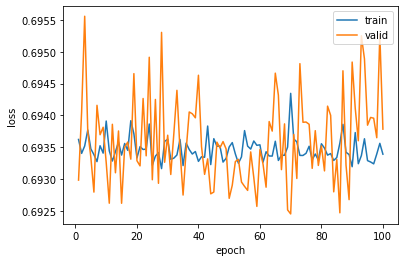

In [49]:
rn34_trainer.learning_curve()

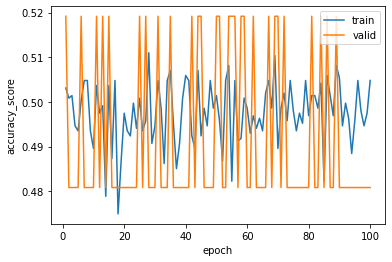

In [50]:
rn34_trainer.learning_curve(y='accuracy_score')

In [51]:
sort_epochs(rn34_trainer.evalutator, 'accuracy_score')

AttributeError: 'trainer' object has no attribute 'evalutator'

# resnet 152

In [52]:
rn_152 = models.resnet152(pretrained=True)

rn_152.conv1 = nn.Conv2d(1, rn_152.conv1.out_channels,
              kernel_size=rn_152.conv1.kernel_size[0], 
                      stride=rn_152.conv1.stride[0], 
                      padding=rn_152.conv1.padding[0])
num_ftrs = rn_152.fc.in_features
rn_152.fc = nn.Linear(num_ftrs, 2)

rn_152.post_forward = post_forward

rn_152_trainer = trainer(rn_152, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [53]:
rn_152_trainer.train(100, lr=0.01, weight_decay=0.2)

Total:   0%|          | 0/448000 [00:00<?, ?it/s]

  1 18.48s trainloss=1.04976 validloss=0.69524 accuracy_score=0.60271 
  2 18.48s trainloss=0.65312 validloss=0.73284 accuracy_score=0.47968 
  3 18.46s trainloss=0.62071 validloss=21.96666 accuracy_score=0.54402 
  4 18.51s trainloss=0.57606 validloss=1.90574 accuracy_score=0.55643 
  5 18.67s trainloss=0.57509 validloss=0.72433 accuracy_score=0.47968 
  6 18.59s trainloss=0.57246 validloss=0.67453 accuracy_score=0.68397 
  7 18.76s trainloss=0.56642 validloss=1.45946 accuracy_score=0.48081 
  8 18.61s trainloss=0.56498 validloss=1.58882 accuracy_score=0.60384 
  9 14.76s trainloss=0.55794 validloss=0.94594 accuracy_score=0.48194 
 10 12.86s trainloss=0.52629 validloss=0.76213 accuracy_score=0.50113 
 11 12.54s trainloss=0.50073 validloss=0.65506 accuracy_score=0.49210 
 12 12.51s trainloss=0.48033 validloss=1.23619 accuracy_score=0.71670 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 13 12.57s trainloss=0.47573 validloss=1.16034 accuracy_score=0.48081 
 14 12.55s trainloss=0.48239 validloss=0.62951 accuracy_score=0.51919 
 15 12.52s trainloss=0.46680 validloss=0.69159 accuracy_score=0.46163 
 16 12.55s trainloss=0.44070 validloss=0.52115 accuracy_score=0.73138 
 17 12.53s trainloss=0.46015 validloss=0.54002 accuracy_score=0.73476 
 18 12.59s trainloss=0.44986 validloss=0.54118 accuracy_score=0.76637 
 19 12.46s trainloss=0.43588 validloss=0.54013 accuracy_score=0.76975 
 20 12.47s trainloss=0.41904 validloss=0.51750 accuracy_score=0.76975 
 21 12.58s trainloss=0.40743 validloss=0.46011 accuracy_score=0.81377 
 22 12.39s trainloss=0.41951 validloss=0.45948 accuracy_score=0.78442 
 23 12.36s trainloss=0.39386 validloss=0.50067 accuracy_score=0.77314 
 24 12.54s trainloss=0.39704 validloss=0.76765 accuracy_score=0.49549 
 25 12.69s trainloss=0.38704 validloss=0.50301 accuracy_score=0.75621 
 26 12.68s trainloss=0.41221 validloss=0.61123 accuracy_score=0.76862 
 27 12

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 12.19s trainloss=0.35524 validloss=1.00920 accuracy_score=0.48081 
 88 12.20s trainloss=0.33736 validloss=0.91642 accuracy_score=0.66140 
 89 12.41s trainloss=0.33818 validloss=0.39110 accuracy_score=0.79910 
 90 12.27s trainloss=0.33105 validloss=0.59040 accuracy_score=0.57901 
 91 12.21s trainloss=0.35097 validloss=0.52317 accuracy_score=0.74944 
 92 12.19s trainloss=0.32339 validloss=0.79161 accuracy_score=0.55756 
 93 12.27s trainloss=0.36888 validloss=0.67545 accuracy_score=0.50000 
 94 12.26s trainloss=0.33215 validloss=0.41168 accuracy_score=0.82506 
 95 12.40s trainloss=0.33785 validloss=1.11782 accuracy_score=0.52370 
 96 12.46s trainloss=0.34435 validloss=0.84116 accuracy_score=0.71558 
 97 12.35s trainloss=0.35016 validloss=0.50213 accuracy_score=0.75621 
 98 12.43s trainloss=0.35413 validloss=2.06191 accuracy_score=0.62302 
 99 12.43s trainloss=0.36282 validloss=0.49457 accuracy_score=0.75169 
100 12.76s trainloss=0.38159 validloss=0.66640 accuracy_score=0.67833 


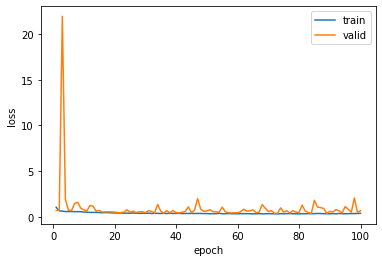

In [54]:
rn_152_trainer.learning_curve()

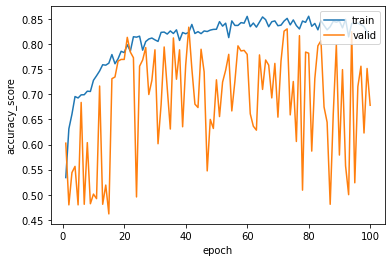

In [55]:
rn_152_trainer.learning_curve(y='accuracy_score')

In [56]:
sort_epochs(rn_152_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_drinking  recall_drinking  recall_other
81         0.834086   41.0       0.798715         0.875587      0.795652
145        0.830700   73.0       0.883333         0.746479      0.908696
143        0.826185   72.0       0.795652         0.859155      0.795652
187        0.825056   94.0       0.824940         0.807512      0.841304
153        0.817156   77.0       0.761905         0.901408      0.739130
..              ...    ...            ...              ...           ...
173        0.480813   87.0       0.480813         1.000000      0.000000
25         0.480813   13.0       0.480813         1.000000      0.000000
9          0.479684    5.0       0.480181         0.995305      0.002174
3          0.479684    2.0       0.480226         0.997653      0.000000
29         0.461625   15.0       0.451056         0.551643      0.378261

[100 rows x 5 columns]


# wide resnet 50_2

In [57]:
rn50_2 = models.wide_resnet50_2(pretrained=True)
rn50_2.conv1 = nn.Conv2d(1, rn50_2.conv1.out_channels,
              kernel_size=rn50_2.conv1.kernel_size[0], 
                      stride=rn50_2.conv1.stride[0], 
                      padding=rn50_2.conv1.padding[0])
num_ftrs = rn50_2.fc.in_features
rn50_2.fc = nn.Linear(num_ftrs, 2)

rn50_2.post_forward = post_forward

rn50_2_trainer = trainer(rn50_2, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [58]:
rn50_2_trainer.train(100, lr=0.01, weight_decay=0.4)

Total:   0%|          | 0/448000 [00:00<?, ?it/s]

  1 9.52s trainloss=0.96899 validloss=0.69238 accuracy_score=0.52032 
  2 9.67s trainloss=0.71267 validloss=0.69457 accuracy_score=0.52483 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  3 9.55s trainloss=0.69846 validloss=0.69395 accuracy_score=0.48081 
  4 9.49s trainloss=0.67253 validloss=1.30961 accuracy_score=0.56885 
  5 9.49s trainloss=0.63272 validloss=1.54224 accuracy_score=0.54853 
  6 9.49s trainloss=0.67237 validloss=1.79062 accuracy_score=0.52822 
  7 9.47s trainloss=0.60208 validloss=124.25471 accuracy_score=0.51919 
  8 9.48s trainloss=0.67488 validloss=0.81069 accuracy_score=0.48194 
  9 9.52s trainloss=0.59874 validloss=0.70905 accuracy_score=0.59932 
 10 9.67s trainloss=0.55227 validloss=0.70868 accuracy_score=0.69977 
 11 9.65s trainloss=0.55905 validloss=0.78612 accuracy_score=0.62415 
 12 9.64s trainloss=0.52046 validloss=0.51140 accuracy_score=0.73815 
 13 9.60s trainloss=0.50847 validloss=0.63306 accuracy_score=0.67946 
 14 9.54s trainloss=0.50193 validloss=0.51151 accuracy_score=0.73928 
 15 9.53s trainloss=0.47298 validloss=0.57836 accuracy_score=0.72009 
 16 9.48s trainloss=0.47997 validloss=2.12906 accuracy_score=0.63318 
 17 9.46s trainlos

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 9.42s trainloss=0.48879 validloss=0.65435 accuracy_score=0.48081 
 43 9.41s trainloss=0.46866 validloss=0.63352 accuracy_score=0.70542 
 44 9.41s trainloss=0.46433 validloss=0.62688 accuracy_score=0.64560 
 45 9.42s trainloss=0.48113 validloss=0.46415 accuracy_score=0.76637 
 46 9.40s trainloss=0.50221 validloss=0.53705 accuracy_score=0.66366 
 47 9.40s trainloss=0.48833 validloss=0.53957 accuracy_score=0.74266 
 48 9.40s trainloss=0.48409 validloss=0.50412 accuracy_score=0.72235 
 49 9.37s trainloss=0.47454 validloss=0.54916 accuracy_score=0.73251 
 50 9.46s trainloss=0.46975 validloss=0.49002 accuracy_score=0.75169 
 51 9.42s trainloss=0.48864 validloss=0.60301 accuracy_score=0.71783 
 52 9.41s trainloss=0.47670 validloss=0.60942 accuracy_score=0.70316 
 53 9.40s trainloss=0.46769 validloss=0.50132 accuracy_score=0.73928 
 54 9.36s trainloss=0.44978 validloss=0.63140 accuracy_score=0.61851 
 55 9.37s trainloss=0.45579 validloss=0.46277 accuracy_score=0.76298 
 56 9.37s trainloss=

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 64 9.32s trainloss=0.49554 validloss=0.63535 accuracy_score=0.48081 
 65 9.51s trainloss=0.48213 validloss=0.84446 accuracy_score=0.62528 
 66 9.41s trainloss=0.46242 validloss=1.33301 accuracy_score=0.61851 
 67 9.42s trainloss=0.46814 validloss=0.61563 accuracy_score=0.66591 
 68 9.39s trainloss=0.47925 validloss=0.62225 accuracy_score=0.52483 
 69 9.41s trainloss=0.47771 validloss=0.68287 accuracy_score=0.61851 
 70 9.39s trainloss=0.48841 validloss=0.64042 accuracy_score=0.48194 
 71 9.38s trainloss=0.49275 validloss=0.64385 accuracy_score=0.48194 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 72 9.39s trainloss=0.47391 validloss=0.66185 accuracy_score=0.48081 
 73 9.40s trainloss=0.47304 validloss=0.50081 accuracy_score=0.75847 
 74 9.44s trainloss=0.46908 validloss=5.37714 accuracy_score=0.52370 
 75 9.44s trainloss=0.48309 validloss=0.76714 accuracy_score=0.65576 
 76 9.46s trainloss=0.47161 validloss=0.65620 accuracy_score=0.67269 
 77 9.49s trainloss=0.47722 validloss=1.69352 accuracy_score=0.55530 
 78 9.45s trainloss=0.49431 validloss=0.75286 accuracy_score=0.48420 
 79 9.37s trainloss=0.47765 validloss=0.53660 accuracy_score=0.70090 
 80 9.32s trainloss=0.48600 validloss=0.65611 accuracy_score=0.49323 
 81 9.35s trainloss=0.56039 validloss=0.56094 accuracy_score=0.70203 
 82 9.35s trainloss=0.51371 validloss=0.61682 accuracy_score=0.70203 
 83 9.41s trainloss=0.50979 validloss=0.59714 accuracy_score=0.72009 
 84 9.43s trainloss=0.48095 validloss=0.52992 accuracy_score=0.72799 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 9.46s trainloss=0.47048 validloss=0.67642 accuracy_score=0.48081 
 86 9.42s trainloss=0.48762 validloss=0.69366 accuracy_score=0.52144 
 87 9.36s trainloss=0.52061 validloss=0.69449 accuracy_score=0.53612 
 88 9.35s trainloss=0.50981 validloss=0.62254 accuracy_score=0.69187 
 89 9.40s trainloss=0.48685 validloss=28.41079 accuracy_score=0.51580 
 90 9.43s trainloss=0.50766 validloss=0.78580 accuracy_score=0.60948 
 91 9.38s trainloss=0.50327 validloss=0.66579 accuracy_score=0.48307 
 92 9.44s trainloss=0.48242 validloss=0.52030 accuracy_score=0.68962 
 93 9.37s trainloss=0.51925 validloss=0.69125 accuracy_score=0.47968 
 94 9.27s trainloss=0.48693 validloss=0.75252 accuracy_score=0.60835 
 95 9.25s trainloss=0.48688 validloss=0.61810 accuracy_score=0.71445 
 96 9.26s trainloss=0.51183 validloss=0.52982 accuracy_score=0.74379 
 97 9.38s trainloss=0.50902 validloss=0.82993 accuracy_score=0.59932 
 98 9.42s trainloss=0.50376 validloss=0.61911 accuracy_score=0.62528 
 99 9.54s trainloss

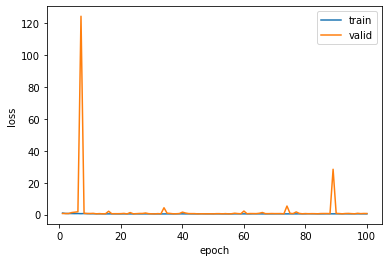

In [59]:
rn50_2_trainer.learning_curve()

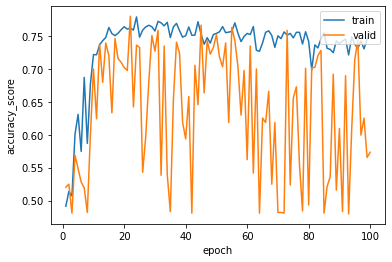

In [60]:
rn50_2_trainer.learning_curve(y='accuracy_score')

In [61]:
sort_epochs(rn50_2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_drinking  recall_drinking  recall_other
43         0.779910   22.0       0.783784         0.748826      0.808696
89         0.766366   45.0       0.754060         0.762911      0.769565
109        0.762980   55.0       0.772727         0.718310      0.804348
61         0.758465   31.0       0.703846         0.859155      0.665217
145        0.758465   73.0       0.756039         0.734742      0.780435
..              ...    ...            ...              ...           ...
127        0.480813   64.0       0.480813         1.000000      0.000000
5          0.480813    3.0       0.480813         1.000000      0.000000
143        0.480813   72.0       0.480813         1.000000      0.000000
169        0.480813   85.0       0.480813         1.000000      0.000000
185        0.479684   93.0       0.480226         0.997653      0.000000

[100 rows x 5 columns]


# resnet 50

In [16]:
rn50 = models.resnet50(pretrained=True)
rn50.conv1 = nn.Conv2d(1, rn50.conv1.out_channels,
              kernel_size=rn50.conv1.kernel_size[0], 
                      stride=rn50.conv1.stride[0], 
                      padding=rn50.conv1.padding[0])
num_ftrs = rn50.fc.in_features
rn50.fc = nn.Linear(num_ftrs, 2)

rn50.post_forward = post_forward

rn50_trainer = trainer(rn50, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [ ]:
rn50_trainer.train(100, lr=0.01)

Total:   0%|          | 0/448000 [00:00<?, ?it/s]

  1 24.07s trainloss=1.32390 validloss=1.41972 accuracy_score=0.56321 
  2 6.44s trainloss=0.65278 validloss=0.75836 accuracy_score=0.51467 
  3 5.73s trainloss=0.60840 validloss=2.05848 accuracy_score=0.41309 
  4 5.73s trainloss=0.59328 validloss=1.47242 accuracy_score=0.60384 
  5 5.74s trainloss=0.57407 validloss=0.94536 accuracy_score=0.60722 
  6 5.84s trainloss=0.56587 validloss=0.83030 accuracy_score=0.66140 
  7 5.76s trainloss=0.54272 validloss=0.64859 accuracy_score=0.64560 
  8 5.77s trainloss=0.49231 validloss=0.77810 accuracy_score=0.70542 
  9 5.76s trainloss=0.44855 validloss=0.52917 accuracy_score=0.74041 
 10 5.76s trainloss=0.42634 validloss=0.55516 accuracy_score=0.76298 
 11 5.78s trainloss=0.40312 validloss=1.42631 accuracy_score=0.67494 
 12 5.78s trainloss=0.38168 validloss=1.38393 accuracy_score=0.50451 
 13 5.78s trainloss=0.37061 validloss=0.89338 accuracy_score=0.53047 
 14 5.79s trainloss=0.34587 validloss=0.63154 accuracy_score=0.64786 
 15 5.78s trainloss

In [ ]:
rn50_trainer.learning_curve()

In [ ]:
rn50_trainer.learning_curve(y='accuracy_score')

In [ ]:
sort_epochs(rn50_trainer.evaluator, 'accuracy_score')

# End notebook

In [ ]:
%%javascript
Jupyter.notebook.session.delete();